# AutoGluon Time Series - Forecasting Quick Start

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/stable/docs/tutorials/timeseries/forecasting-quick-start.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/stable/docs/tutorials/timeseries/forecasting-quick-start.ipynb)


Via a simple `fit()` call, AutoGluon can train and tune

- simple forecasting models (e.g., ARIMA, ETS, Theta),
- powerful deep learning models (e.g., DeepAR, Temporal Fusion Transformer),
- tree-based models (e.g., LightGBM),
- an ensemble that combines predictions of other models

to produce multi-step ahead _probabilistic_ forecasts for univariate time series data.

This tutorial demonstrates how to quickly start using AutoGluon to generate hourly forecasts for the [M4 forecasting competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) dataset.

## Loading time series data as a `TimeSeriesDataFrame`

First, we import some required modules

In [4]:
# We use uv for faster installation
!pip install autogluon.timeseries


  Using cached accelerate-0.21.0-py3-none-any.whl (244 kB)
     --------------------------------------- 11.6/11.6 MB 81.8 MB/s eta 0:00:00
     ---------------------------------------- 9.0/9.0 MB 96.7 MB/s eta 0:00:00
     --------------------------------------- 46.2/46.2 MB 59.5 MB/s eta 0:00:00
     --------------------------------------- 10.6/10.6 MB 54.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.0
    Uninstalling scipy-1.13.0:
      Successfully uninstalled scipy-1.13.0


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Isaiah\\AppData\\Roaming\\Python\\Python310\\site-packages\\~cipy.libs\\libopenblas_v0.3.26-382-gb1e8ba50--72a863714eca5a50b38260dedc0c2f3a.dll'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip available: 22.3 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


To use `autogluon.timeseries`, we will only need the following two classes:

- `TimeSeriesDataFrame` stores a dataset consisting of multiple time series.
- `TimeSeriesPredictor` takes care of fitting, tuning and selecting the best forecasting models, as well as generating new forecasts.

We load a subset of the M4 hourly dataset as a `pandas.DataFrame`

In [3]:
df = pd.read_csv("Scripts/autogluon.csv")
df.head()

,item_id,timestamp,target
0,1,2000-01-03 00:00:00,69.700
1,2,2000-01-04 00:00:00,69.075
2,3,2000-01-05 00:00:00,68.975
3,4,2000-01-06 00:00:00,70.075
4,5,2000-01-07 00:00:00,70.875


AutoGluon expects time series data in [long format](https://doc.dataiku.com/dss/latest/time-series/data-formatting.html#long-format).
Each row of the data frame contains a single observation (timestep) of a single time series represented by

- unique ID of the time series (`"item_id"`) as int or str
- timestamp of the observation (`"timestamp"`) as a `pandas.Timestamp` or compatible format
- numeric value of the time series (`"target"`)

The raw dataset should always follow this format with at least three columns for unique ID, timestamp, and target value, but the names of these columns can be arbitrary.
It is important, however, that we provide the names of the columns when constructing a `TimeSeriesDataFrame` that is used by AutoGluon.
AutoGluon will raise an exception if the data doesn't match the expected format.

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,item_id,timestamp,target
0,1,2000-01-03,69.700
1,2,2000-01-04,69.075
2,3,2000-01-05,68.975
3,4,2000-01-06,70.075
4,5,2000-01-07,70.875


In [7]:
df['year'] = df['timestamp'].dt.to_period('Y')
df.head()

,item_id,timestamp,target,month,year
0,1,2000-01-03,69.700,2000,2000
1,2,2000-01-04,69.075,2000,2000
2,3,2000-01-05,68.975,2000,2000
3,4,2000-01-06,70.075,2000,2000
4,5,2000-01-07,70.875,2000,2000


In [8]:
df['item_id'] = df['year'].rank(method='dense').astype(int)
# Drop the 'month' column as it's no longer needed
df.drop(columns=['month'], inplace=True)
df.drop(columns=['year'], inplace=True)

df.head()

,item_id,timestamp,target
0,1,2000-01-03,69.700
1,1,2000-01-04,69.075
2,1,2000-01-05,68.975
3,1,2000-01-06,70.075
4,1,2000-01-07,70.875


In [9]:
df['target'].ffill(inplace = True)

In [10]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into train and test sets
# train_data, test_df = train_test_split(df, test_size=0.3, random_state=42)

split_index = int(len(df) * 0.8)

# Split the DataFrame into train and test sets
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Write the train and test sets to CSV files
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)
# train_data.to_csv('train_data.csv', index=False)
# test_data.to_csv('test_data.csv', index=False)

df = train_df

In [11]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()


target
item_id timestamp         
1       2000-01-03  69.700
        2000-01-04  69.075
        2000-01-05  68.975
        2000-01-06  70.075
        2000-01-07  70.875

In [57]:
train_data.head(-1)

target
item_id timestamp          
1       2000-01-03   69.700
        2000-01-04   69.075
        2000-01-05   68.975
        2000-01-06   70.075
        2000-01-07   70.875
...                     ...
197     2016-05-19  121.550
        2016-05-20  121.050
        2016-05-23  118.150
        2016-05-24  118.000
        2016-05-25  118.150

[4230 rows x 1 columns]

In [180]:
train_data = train_data.fill_missing_values()
train_data.head()

target
item_id timestamp         
1       2000-01-03  69.700
        2000-01-04  69.075
        2000-01-05  68.975
        2000-01-06  70.075
        2000-01-07  70.875

We refer to each individual time series stored in a `TimeSeriesDataFrame` as an _item_.
For example, items might correspond to different products in demand forecasting, or to different stocks in financial datasets.
This setting is also referred to as a _panel_ of time series.
Note that this is *not* the same as multivariate forecasting — AutoGluon generates forecasts for each time series individually, without modeling interactions between different items (time series).

`TimeSeriesDataFrame` inherits from [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), so all attributes and methods of `pandas.DataFrame` are available in a `TimeSeriesDataFrame`.
It also provides other utility functions, such as loaders for different data formats (see [TimeSeriesDataFrame](../../api/autogluon.timeseries.TimeSeriesDataFrame) for details).

## Training time series models with `TimeSeriesPredictor.fit`
To forecast future values of the time series, we need to create a `TimeSeriesPredictor` object.

Models in `autogluon.timeseries` forecast time series _multiple steps_ into the future.
We choose the number of these steps — the _prediction length_ (also known as the _forecast horizon_) —  depending on our task.
For example, our dataset contains time series measured at hourly _frequency_, so we set `prediction_length = 48` to train models that forecast up to 48 hours into the future.

We instruct AutoGluon to save trained models in the folder `./autogluon-m4-hourly`.
We also specify that AutoGluon should rank models according to [mean absolute scaled error (MASE)](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error), and that data that we want to forecast is stored in the column `"target"` of the `TimeSeriesDataFrame`.

In [18]:
TimeSeriesPredictor(freq='M')

In [19]:
train_data.convert_frequency(freq='M')

target
item_id timestamp             
1       2000-01-31   70.121429
        2000-02-29   70.076190
        2000-03-31   72.510870
        2000-04-30   73.228750
        2000-05-31   68.109783
...                        ...
19      2018-05-31  104.943478
        2018-06-30  107.629762
        2018-07-31  107.097727
        2018-08-31  108.630435
        2018-09-30  111.421053

[225 rows x 1 columns]

In [22]:
predictor = TimeSeriesPredictor(
    prediction_length=3,
    path="autogloun-daily",
    target="target",
    eval_metric="MASE",
    freq = 'M',
)

predictor.fit(
    df,
    presets="medium_quality",
    time_limit=1200,
)


Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to 'autogloun-daily'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.7
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.5.0: Wed May  1 20:09:52 PDT 2024; root:xnu-10063.121.3~5/RELEASE_X86_64
CPU Count:          8
GPU Count:          0
Memory Avail:       14.72 GB / 32.00 GB (46.0%)
Disk Space Avail:   838.56 GB / 931.55 GB (90.0%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'M',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 3,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 1200,
 'verbosity': 2}

train_data with frequ

Here we used the `"medium_quality"` presets and limited the training time to 10 minutes (600 seconds).
The presets define which models AutoGluon will try to fit.
For `medium_quality` presets, these are
simple baselines (`Naive`, `SeasonalNaive`),
statistical models (`ETS`, `Theta`),
tree-based models based on LightGBM (`RecursiveTabular`, `DirectTabular`),
a deep learning model `TemporalFusionTransformer`,
and a weighted ensemble combining these.
Other available presets for `TimeSeriesPredictor` are `"fast_training"`, `"high_quality"` and `"best_quality"`.
Higher quality presets will usually produce more accurate forecasts but take longer to train.

Inside `fit()`, AutoGluon will train as many models as possible within the given time limit.
Trained models are then ranked based on their performance on an internal validation set.
By default, this validation set is constructed by holding out the last `prediction_length` timesteps of each time series in `train_data`.


## Generating forecasts with `TimeSeriesPredictor.predict`

We can now use the fitted `TimeSeriesPredictor` to forecast the future time series values.
By default, AutoGluon will make forecasts using the model that had the best score on the internal validation set.
The forecast always includes predictions for the next `prediction_length` timesteps, starting from the end of each time series in `train_data`.

In [25]:
predictions = predictor.predict(train_data)
predictions.head()


data with frequency 'None' has been resampled to frequency 'M'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean        0.1        0.2        0.3        0.4  \
item_id timestamp                                                           
1       2001-01-31  75.592449  71.328847  72.870401  73.451297  74.702577   
        2001-02-28  75.378406  69.947996  71.831647  72.892280  74.256871   
        2001-03-31  75.318909  68.968552  71.148334  72.521165  74.012592   
2       2002-01-31  65.182033  61.124882  62.421230  63.017053  64.394463   
        2002-02-28  65.023209  59.606163  61.355492  62.469848  63.924501   

                          0.5        0.6        0.7        0.8        0.9  
item_id timestamp                                                          
1       2001-01-31  75.592449  76.301620  77.266476  78.193022  79.689936  
        2001-02-28  75.378406  76.343528  77.456463  78.694020  80.580856  
        2001-03-31  75.318909  76.478016  77.731563  79.198688  81.408602  
2       2002-01-31  65.182033  65.898445  66.766542  67.637875  69.074464  
        2002-02-28  65.023209  65.969174  67.009505  68.199143  70.072434

AutoGluon produces a _probabilistic_ forecast: in addition to predicting the mean (expected value) of the time series in the future, models also provide the quantiles of the forecast distribution.
The quantile forecasts give us an idea about the range of possible outcomes.
For example, if the `"0.1"` quantile is equal to `500.0`, it means that the model predicts a 10% chance that the target value will be below `500.0`.

We will now visualize the forecast and the actually observed values for one of the time series in the dataset.
We plot the mean forecast, as well as the 10% and 90% quantiles to show the range of potential outcomes.

In [195]:
predictions.to_csv('predicted.csv', index=True)

In [26]:
import matplotlib.pyplot as plt

# # TimeSeriesDataFrame can also be loaded directly from a file
# test_data = TimeSeriesDataFrame.from_path("train_data.csv")

# # Plot 4 randomly chosen time series and the respective forecasts
# predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=10);
# plt.show()

def plot_predictions(train_data, predictions, item_id, target_column, titel, ylabel):
    plt.figure(figsize=(12,5))
    plt.title(titel)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    # timeseries data
    y_train = train_data.loc[item_id][target_column]
    plt.plot(y_train, label="Timeseries Data", color='blue')
    # forcast data
    y_pred = predictions.loc[item_id]
    plt.plot(y_pred['mean'], label="Mean Forecast", color='orange')
    # confidence intervals
    plt.fill_between(
        y_pred.index , y_pred['0.1'], y_pred['0.9'],
        color='red', alpha=0.1, label='10%-90% Confidence Range'
    )

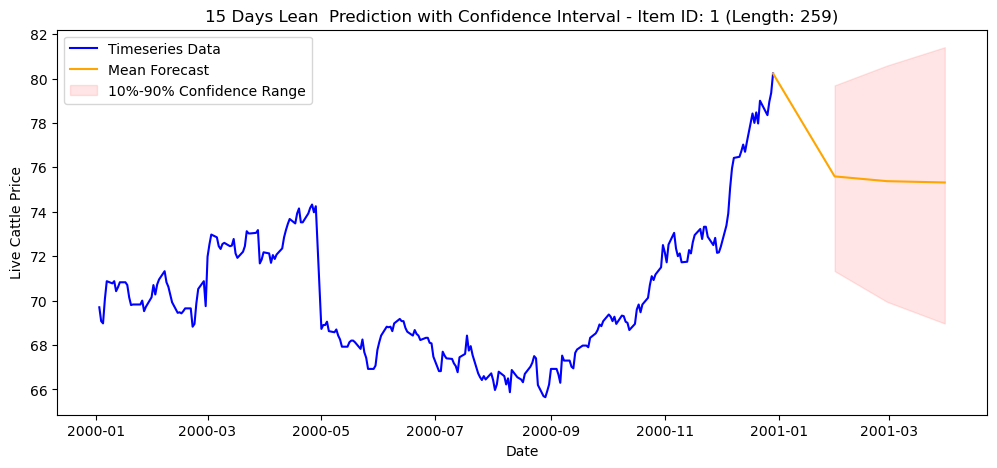

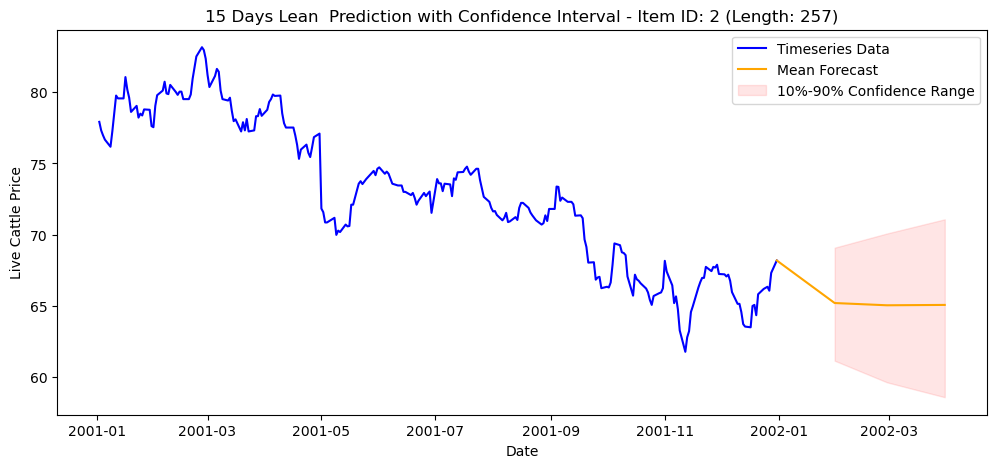

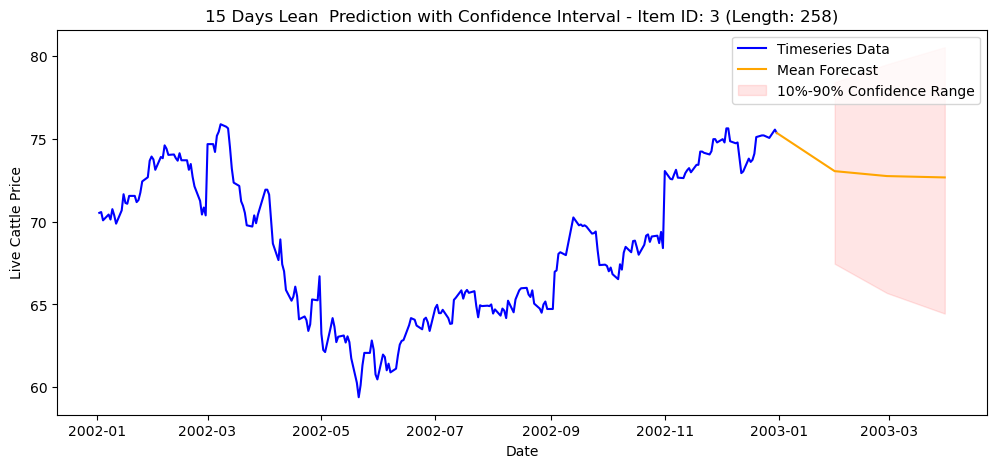

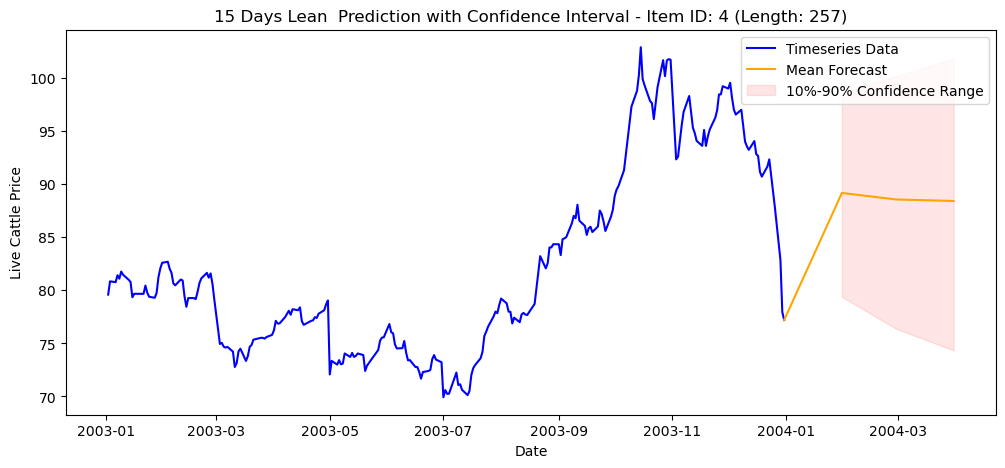

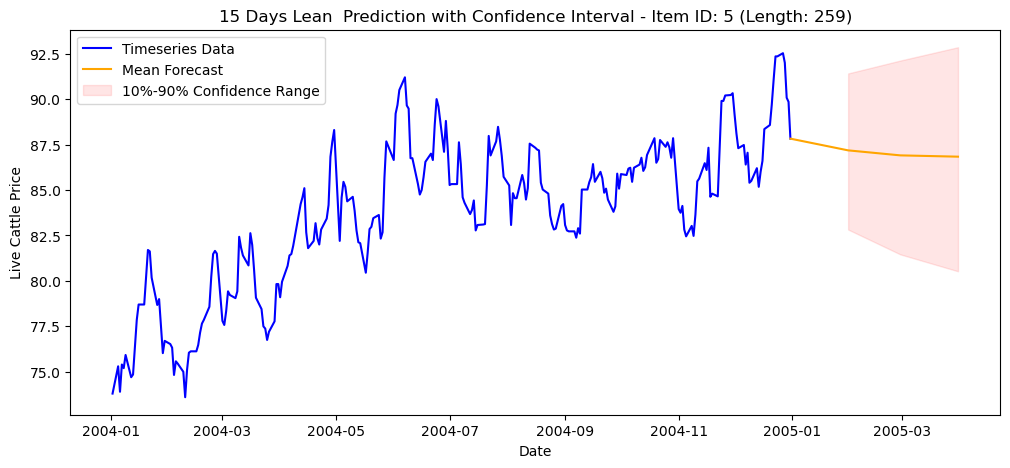

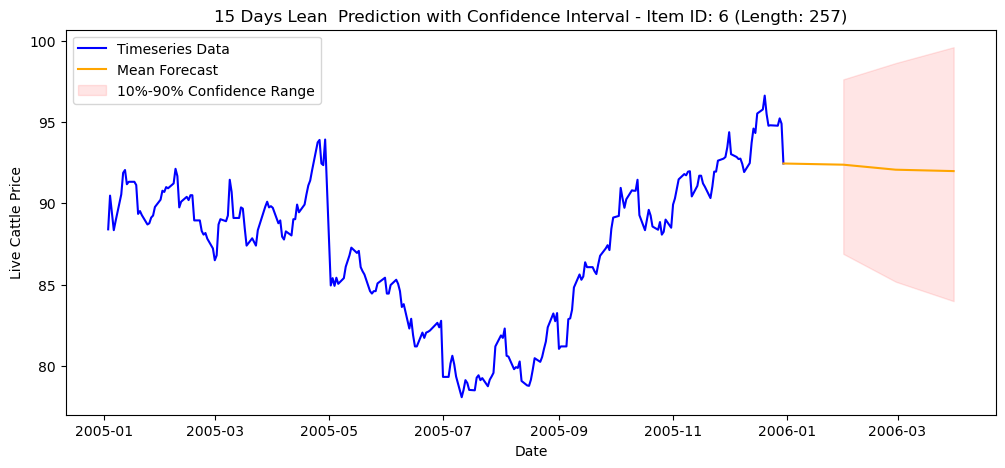

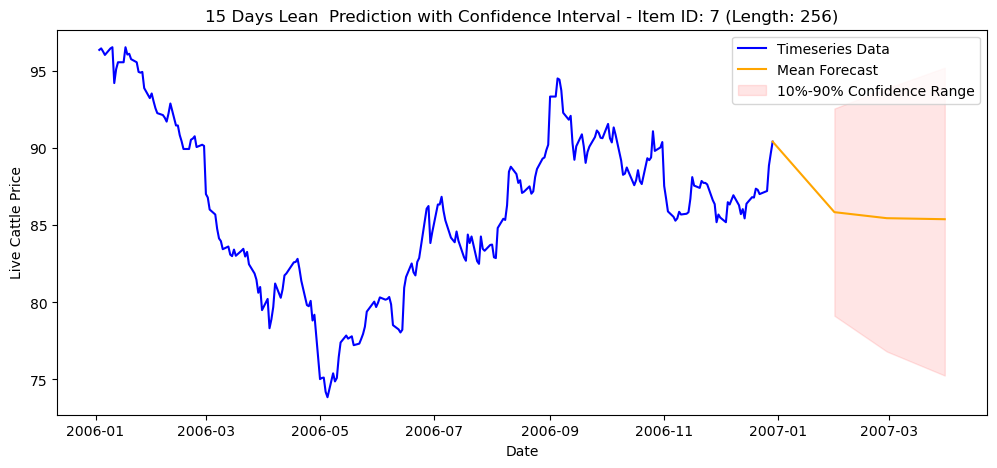

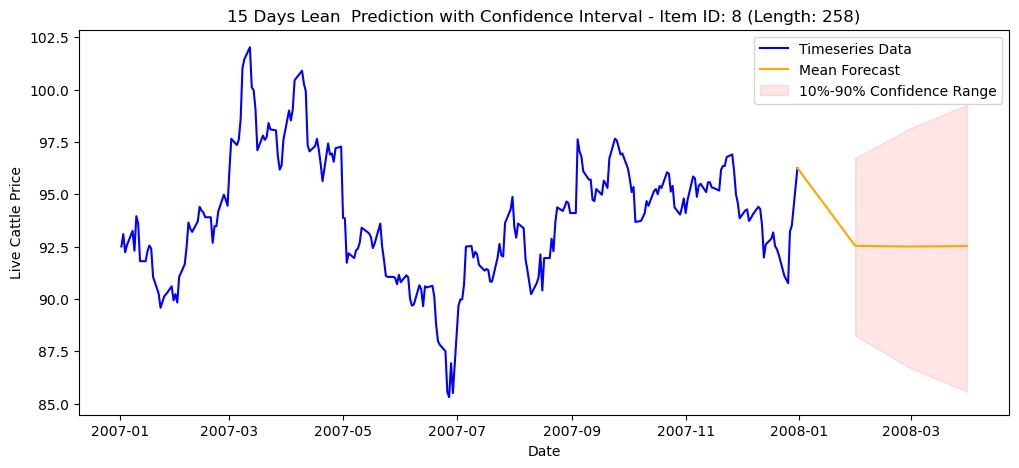

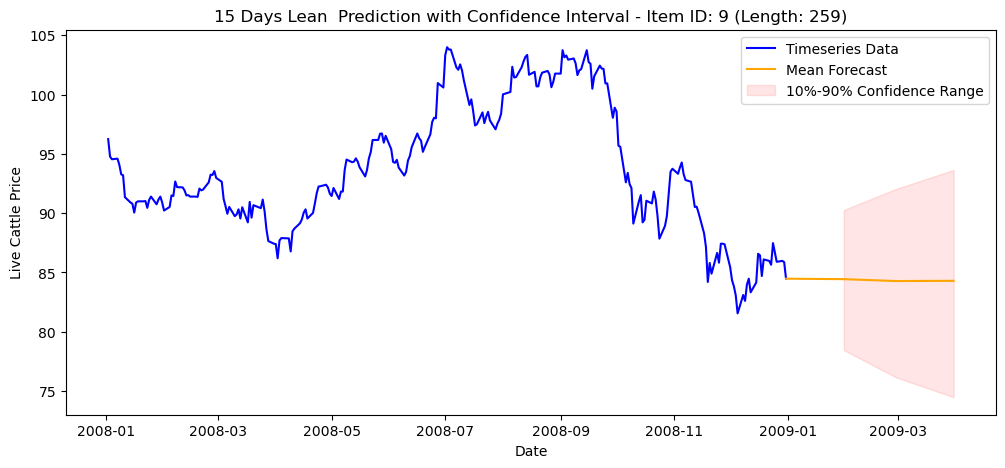

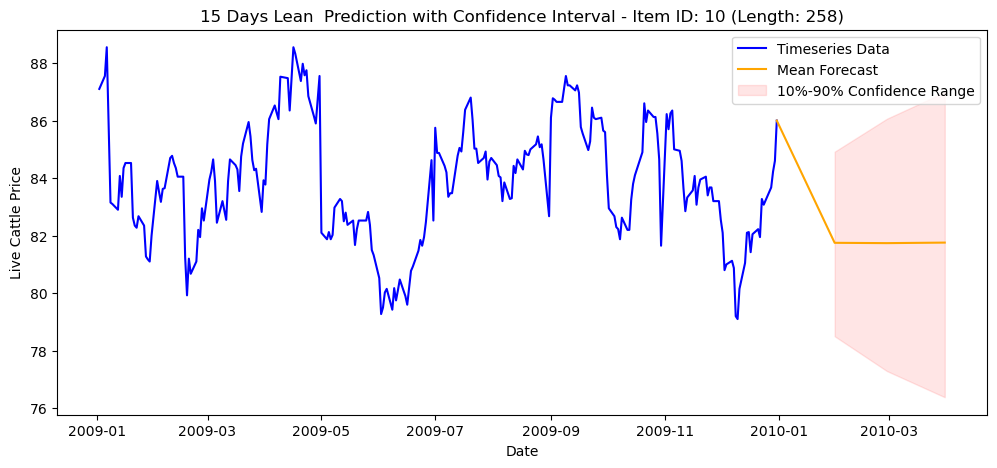

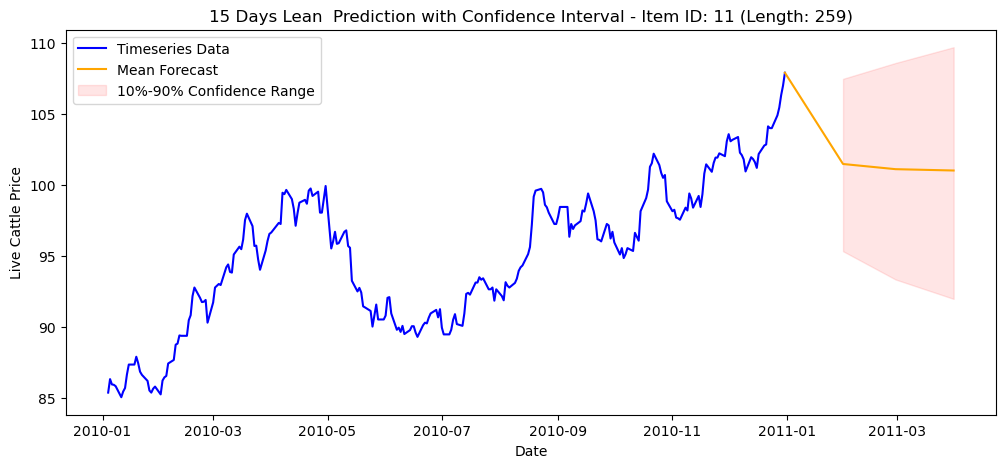

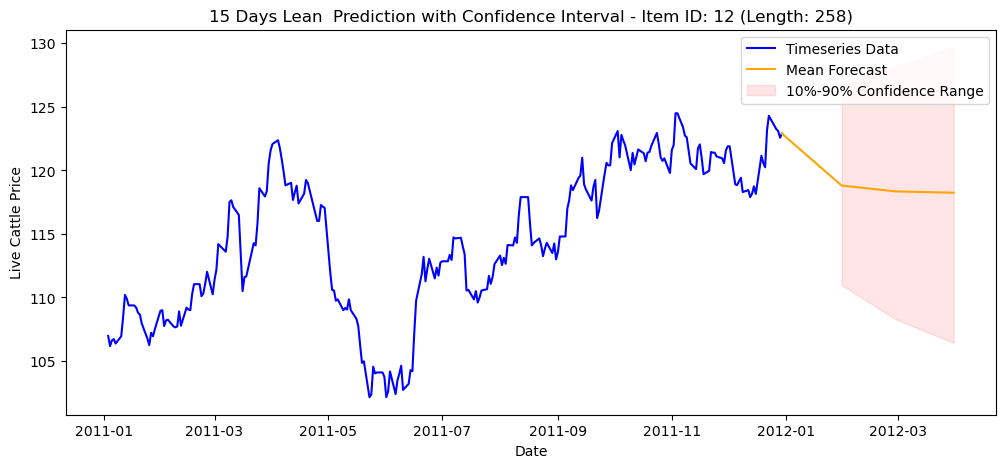

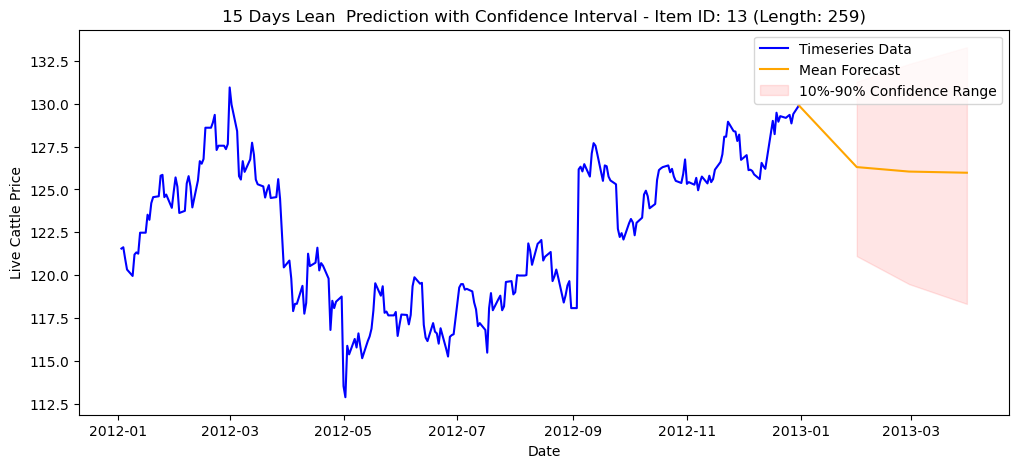

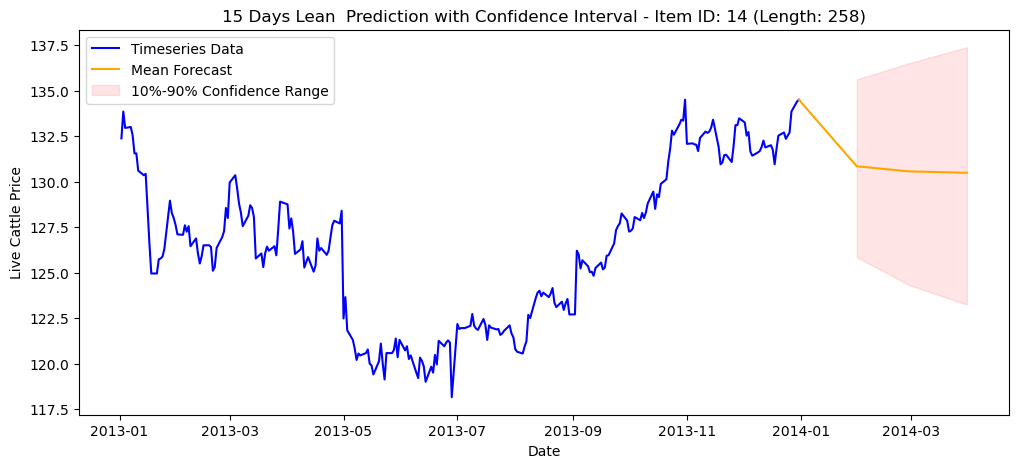

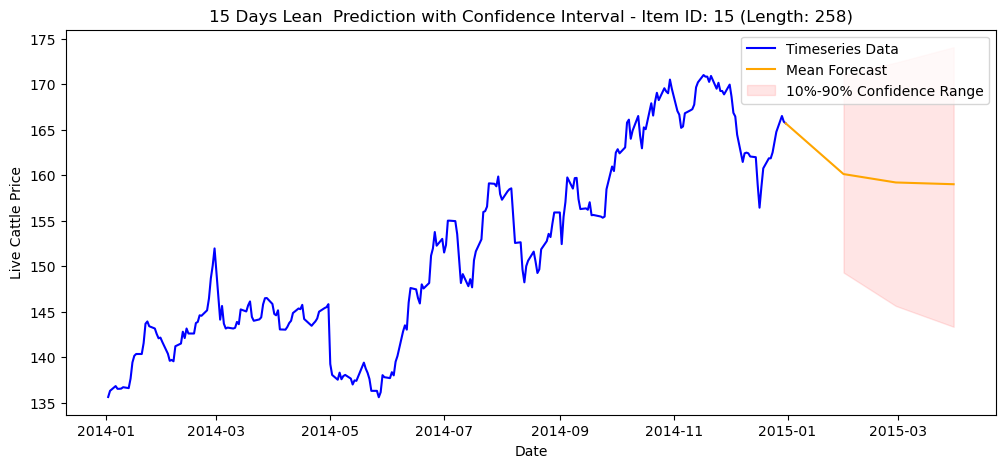

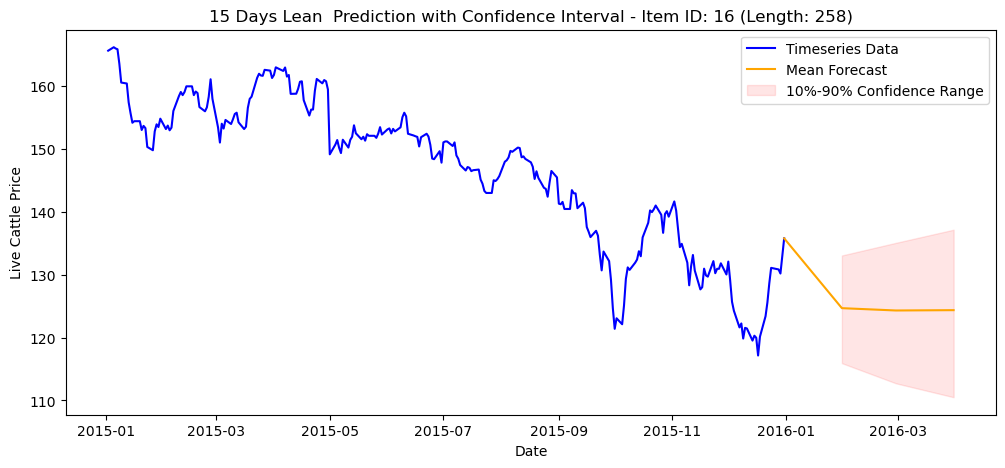

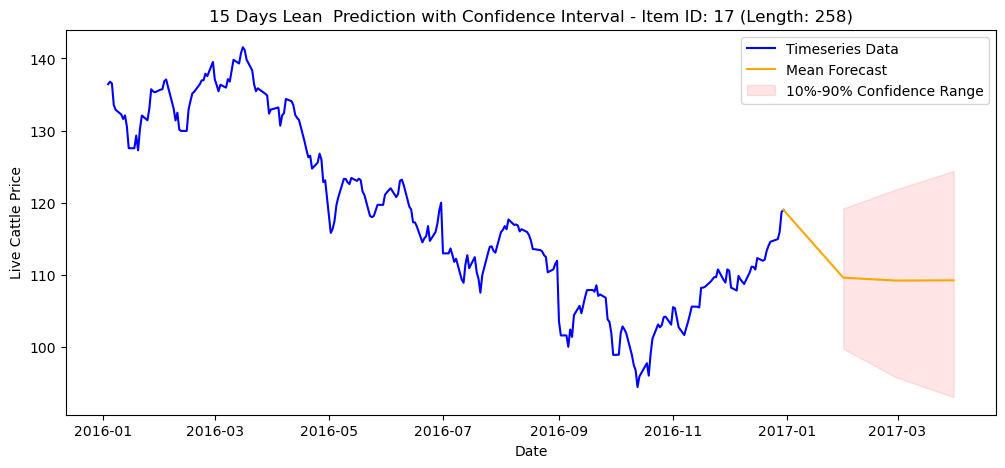

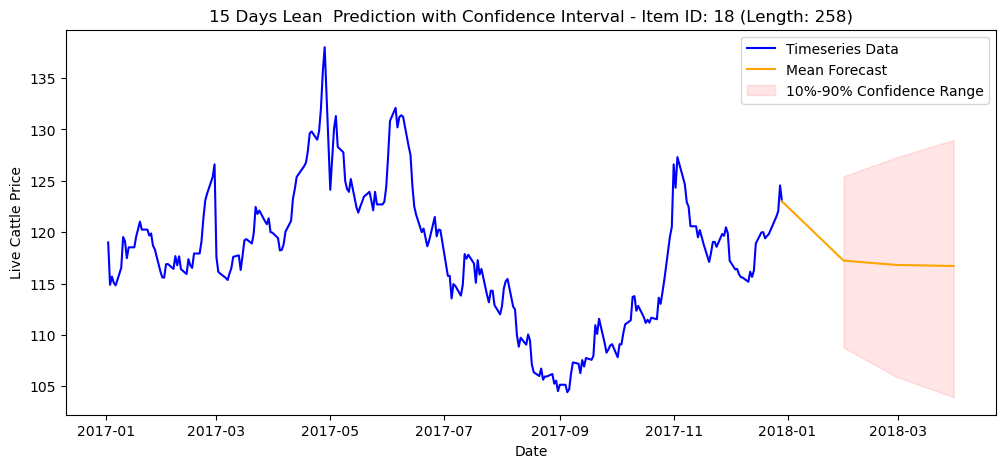

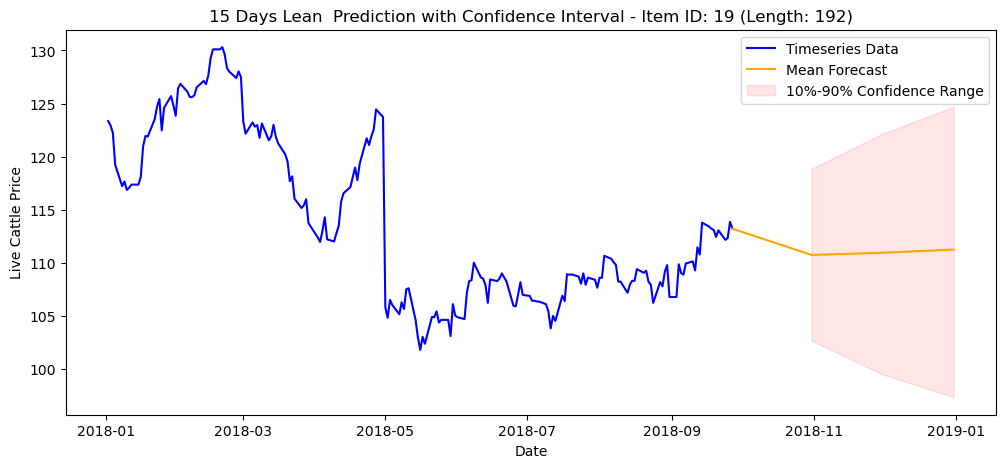

In [28]:
import matplotlib.pyplot as plt

def plot_all_predictions(train_data, predictions, target_column, title, ylabel):
    for item_id in train_data.index.get_level_values(0).unique():
        plt.figure(figsize=(12, 5))
        plt.title(f"{title} - Item ID: {item_id} (Length: {len(train_data.loc[item_id])})")
        plt.xlabel('Date')
        plt.ylabel(ylabel)
        
        # Extract time series data
        y_train = train_data.loc[item_id][target_column]
        plt.plot(y_train.index, y_train, label="Timeseries Data", color='blue')
        
        # Extract forecast data
        y_pred = predictions.loc[item_id]
        
        # Prepare the prediction series with the last training point
        y_pred_with_last_train = pd.Series(
            [y_train.iloc[-1]] + list(y_pred['mean']), 
            index=[y_train.index[-1]] + list(y_pred.index)
        )
        
        # Plot the mean forecast
        plt.plot(y_pred_with_last_train.index, y_pred_with_last_train, label="Mean Forecast", color='orange')
        
        # Plot the confidence intervals
        plt.fill_between(
            y_pred.index, y_pred['0.1'], y_pred['0.9'],
            color='red', alpha=0.1, label='10%-90% Confidence Range'
        )
        
        plt.legend()
        plt.show()

# Example usage
plot_all_predictions(
    train_data, predictions,
    target_column='target',
    title='15 Days Lean  Prediction with Confidence Interval',
    ylabel='Live Cattle Price'
)
# plt.savefig('assets/AutoGluon_AutoML_TimeSeries_02.webp', bbox_inches='tight')


In [137]:
!pip install mpld3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 3.7 MB/s eta 0:00:00a 0:00:01


In [139]:
# import matplotlib.pyplot as plt
# import mpld3
# import pandas as pd

def plot_all_predictions(train_data, predictions, target_column, title, ylabel, html_filename):
    html_str = ''
    for item_id in train_data.index.get_level_values(0).unique():
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.set_title(f"{title} - Item ID: {item_id} (Length: {len(train_data.loc[item_id])})")
        ax.set_xlabel('Date')
        ax.set_ylabel(ylabel)
        
        # Extract time series data
        y_train = train_data.loc[item_id][target_column]
        ax.plot(y_train.index, y_train, label="Timeseries Data", color='blue')
        
        # Extract forecast data
        y_pred = predictions.loc[item_id]
        
        # Prepare the prediction series with the last training point
        y_pred_with_last_train = pd.Series(
            [y_train.iloc[-1]] + list(y_pred['mean']), 
            index=[y_train.index[-1]] + list(y_pred.index)
        )
        
        # Plot the mean forecast
        ax.plot(y_pred_with_last_train.index, y_pred_with_last_train, label="Mean Forecast", color='orange')
        
        # Plot the confidence intervals
        ax.fill_between(
            y_pred.index, y_pred['0.1'], y_pred['0.9'],
            color='red', alpha=0.1, label='10%-90% Confidence Range'
        )
        
        ax.legend()
        
        # Convert plot to HTML string
        html_str += mpld3.fig_to_html(fig)
        plt.close(fig)
    
    # Save all plots to a single HTML file
    with open(html_filename, 'w') as f:
        f.write(html_str)

# Example usage
plot_all_predictions(
    train_data, predictions,
    target_column='target',
    title='15 Days Commodity Price Prediction with Confidence Interval',
    ylabel='Live Cattle Price',
    html_filename='plots.html'
)


## Evaluating the performance of different models

We can view the performance of each model AutoGluon has trained via the `leaderboard()` method.
We provide the test data set to the leaderboard function to see how well our fitted models are doing on the unseen test data.
The leaderboard also includes the validation scores computed on the internal validation dataset.

Note the test data includes both the forecast horizon (last `prediction_length` values of each time series) as well as the historic data (all except the last `prediction_last` values).

In AutoGluon leaderboards, higher scores always correspond to better predictive performance.
Therefore our MASE scores are multiplied by `-1`, such that higher "negative MASE"s correspond to more accurate forecasts.

In [199]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(test_data)


data with frequency 'None' has been resampled to frequency 'D'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Naive,-1.416703,-1.316868,0.093203,2.466668,0.011894,1
1,WeightedEnsemble,-1.430919,-1.307343,0.362830,2.543312,0.218406,6
2,Theta,-1.523694,-1.417254,57.030244,32.733070,0.025054,4
3,ETS,-1.537931,-1.502439,30.936758,47.225418,0.024298,3
4,SeasonalNaive,-1.679753,-1.469856,0.091539,0.038530,0.014037,2
5,TemporalFusionTransformer,-2.047593,-1.845948,0.176084,0.038114,30.623528,5


## Summary
We used `autogluon.timeseries` to make probabilistic multi-step forecasts on the M4 Hourly dataset.
Check out [Forecasting Time Series - In Depth](forecasting-indepth.ipynb) to learn about the advanced capabilities of AutoGluon for time series forecasting.